# Training Report — NumPy CNN vs PyTorch (MNIST & CIFAR-10)

This notebook runs **quick, reproducible trainings** for your NumPy-from-scratch models, visualizes metrics, and optionally compares with a small PyTorch CNN on the **same subset**.

**What you get**:
- Configurable runs (subset size, epochs, batch size)
- Loss/accuracy curves
- Confusion matrix and classification report
- Side-by-side accuracy comparison with PyTorch (if available)

> Tip: Start with tiny subsets/epochs to keep it fast, then scale up.


In [11]:
import os, sys, time, math, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Ensure project root on path
ROOT = os.path.abspath(os.path.join(os.getcwd()))
if not os.path.isdir(os.path.join(ROOT, 'src')):
    ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print('Project root:', ROOT)

# Project imports
from src.models.convnet_small import lenet_mnist, vgg_tiny_cifar10
from src.models.sequential import Sequential
from src.core.utils import one_hot, make_batches, set_seed
from src.core.losses import softmax_cross_entropy, softmax_cross_entropy_backward
from src.core.metrics import accuracy
from src.core.optim import Adam
from src.data.mnist import load_mnist
from src.data.cifar10 import load_cifar10

print('Imports OK')


Project root: c:\Users\arnov\Desktop\CNN-from-scratch
Imports OK


## Config
Adjust these to control dataset subset sizes and training budget.


In [12]:
CFG = {
    'seed': 42,
    'mnist': {'subset': 5000, 'val_subset': 1000, 'epochs': 5, 'batch': 128, 'lr': 1e-3},
    'cifar10': {'subset': 10000, 'val_subset': 2000, 'epochs': 5, 'batch': 128, 'lr': 1e-3},
}
set_seed(CFG['seed'])
CFG


{'seed': 42,
 'mnist': {'subset': 5000,
  'val_subset': 1000,
  'epochs': 5,
  'batch': 128,
  'lr': 0.001},
 'cifar10': {'subset': 10000,
  'val_subset': 2000,
  'epochs': 5,
  'batch': 128,
  'lr': 0.001}}

## Helper functions: train loop wrapper, plots, confusion matrix


In [13]:
def train_numpy_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=128, lr=1e-3, num_classes=10):
    hist = defaultdict(list)
    opt = Adam(lr=lr)
    model.train()
    N = X_train.shape[0]
    for ep in range(1, epochs+1):
        perm = np.random.permutation(N)
        X_train, y_train = X_train[perm], y_train[perm]
        total_loss = 0.0
        total_correct = 0
        total_seen = 0
        for s, e in make_batches(N, batch_size):
            xb, yb = X_train[s:e], y_train[s:e]
            logits = model.forward(xb, training=True)
            y1 = one_hot(yb, num_classes)
            loss = softmax_cross_entropy(logits, y1)
            grad = softmax_cross_entropy_backward(logits, y1)
            _ = model.backward(grad)
            opt.step(model.params(), model.grads())
            total_loss += loss * (e - s)
            total_correct += int(np.sum(np.argmax(logits, axis=1) == yb))
            total_seen += (e - s)
        train_loss = total_loss / total_seen
        train_acc = total_correct / total_seen
        # validation
        model.eval()
        val_logits = []
        for s, e in make_batches(X_val.shape[0], batch_size):
            val_logits.append(model.forward(X_val[s:e], training=False))
        val_logits = np.concatenate(val_logits, axis=0)
        val_loss = softmax_cross_entropy(val_logits, one_hot(y_val, num_classes))
        val_acc = accuracy(val_logits, y_val)
        model.train()
        hist['train_loss'].append(train_loss)
        hist['train_acc'].append(train_acc)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)
        print(f"[ep {ep:02d}] train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")
    return model, hist

def plot_history(hist, title_prefix=""):
    epochs = range(1, len(hist['train_loss'])+1)
    plt.figure()
    plt.plot(list(epochs), hist['train_loss'], label='train_loss')
    plt.plot(list(epochs), hist['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title_prefix + ' loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(list(epochs), hist['train_acc'], label='train_acc')
    plt.plot(list(epochs), hist['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(title_prefix + ' accuracy')
    plt.legend()
    plt.show()

def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.show()

import numpy as np

def classification_report_np(y_true, y_pred, labels=None, digits=3):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    n = len(labels)
    label_to_idx = {lbl:i for i, lbl in enumerate(labels)}
    # Confusion matrix
    cm = np.zeros((n, n), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1

    support = cm.sum(axis=1)
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    f1 = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall) != 0)

    # Mean
    macro_p = precision.mean() if n > 0 else 0.0
    macro_r = recall.mean() if n > 0 else 0.0
    macro_f1 = f1.mean() if n > 0 else 0.0

    total = support.sum()
    weights = np.divide(support, total, out=np.zeros_like(support, dtype=float), where=total != 0)
    weighted_p = (weights * precision).sum()
    weighted_r = (weights * recall).sum()
    weighted_f1 = (weights * f1).sum()

    micro_tp = tp.sum()
    micro_fp = fp.sum()
    micro_fn = fn.sum()
    micro_p = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) > 0 else 0.0
    micro_r = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) > 0 else 0.0
    micro_f1 = 2*micro_p*micro_r / (micro_p+micro_r) if (micro_p+micro_r) > 0 else 0.0

    # Formatting
    name_w = max(9, max(len(str(lbl)) for lbl in labels))
    fmt = f"{{:{name_w}}}  {{:>{digits+4}.{digits}f}}  {{:>{digits+4}.{digits}f}}  {{:>{digits+4}.{digits}f}}  {{:>7d}}"
    lines = []
    lines.append(f"{'class':{name_w}}  precision  recall  f1-score  support")
    for i, lbl in enumerate(labels):
        lines.append(fmt.format(str(lbl), precision[i], recall[i], f1[i], int(support[i])))
    lines.append("")
    lines.append(fmt.format("accuracy", micro_p, micro_r, micro_f1, int(total)))
    lines.append(fmt.format("macro avg", macro_p, macro_r, macro_f1, int(total)))
    lines.append(fmt.format("weighted avg", weighted_p, weighted_r, weighted_f1, int(total)))
    return "\n".join(lines), {
        "precision": precision, "recall": recall, "f1": f1, "support": support,
        "macro": (macro_p, macro_r, macro_f1),
        "weighted": (weighted_p, weighted_r, weighted_f1),
        "micro": (micro_p, micro_r, micro_f1),
        "cm": cm
    }



## MNIST — NumPy LeNet
We train LeNet on a subset and visualize metrics.


[ep 01] train_loss=1.4851 acc=0.5092 | val_loss=0.6090 acc=0.8120
[ep 02] train_loss=0.5535 acc=0.8206 | val_loss=0.3375 acc=0.8960
[ep 03] train_loss=0.3614 acc=0.8886 | val_loss=0.2398 acc=0.9290
[ep 04] train_loss=0.2733 acc=0.9184 | val_loss=0.2135 acc=0.9300
[ep 05] train_loss=0.2047 acc=0.9420 | val_loss=0.1770 acc=0.9460
NumPy LeNet training time (MNIST subset): 72.42 sec
Learning rate used for each epoch (Adam, constant):
Epoch 1: lr = 0.001
Epoch 2: lr = 0.001
Epoch 3: lr = 0.001
Epoch 4: lr = 0.001
Epoch 5: lr = 0.001


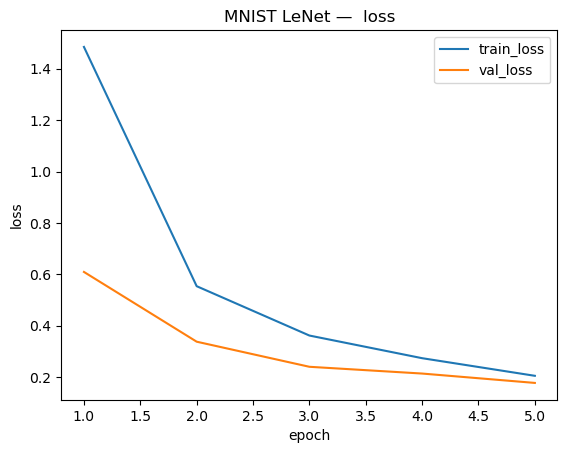

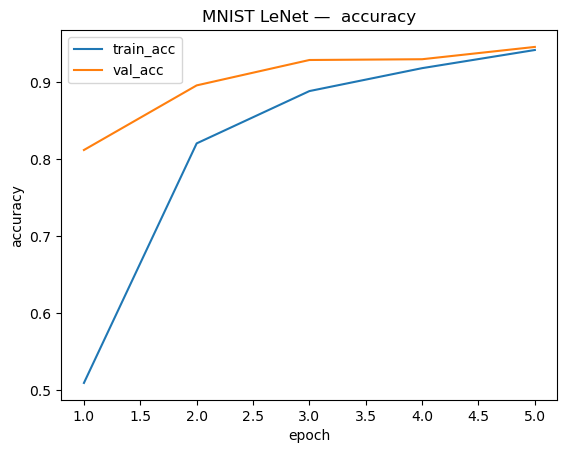

MNIST test accuracy: 0.9446


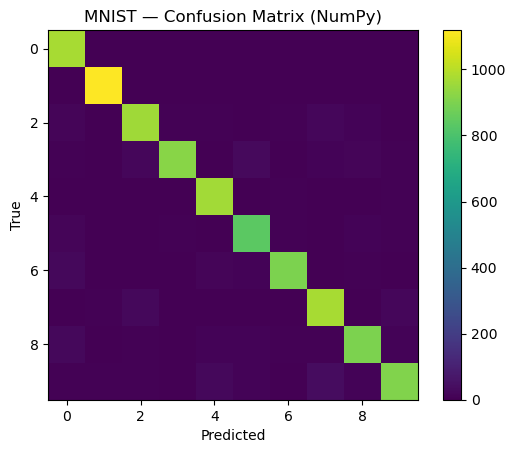

Number of misclassified images: 554


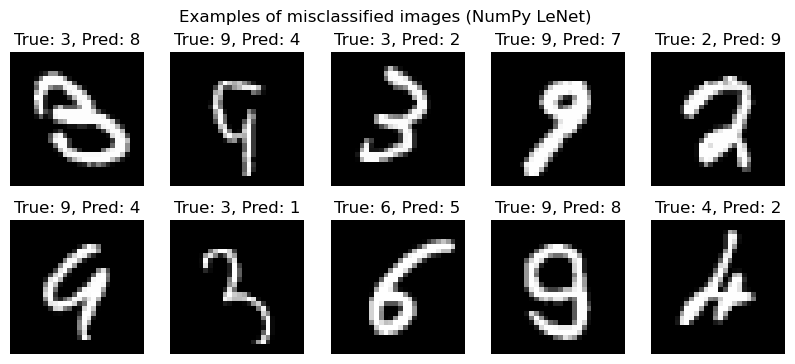

Classification report (NumPy LeNet on MNIST test):
('class      precision  recall  f1-score  support\n0            0.909    0.992    0.949      980\n1            0.982    0.986    0.984     1135\n2            0.940    0.929    0.935     1032\n3            0.978    0.911    0.943     1010\n4            0.940    0.981    0.960      982\n5            0.932    0.939    0.936      892\n6            0.965    0.938    0.951      958\n7            0.923    0.946    0.934     1028\n8            0.931    0.921    0.926      974\n9            0.946    0.899    0.922     1009\n\naccuracy     0.945    0.945    0.945    10000\nmacro avg    0.945    0.944    0.944    10000\nweighted avg    0.945    0.945    0.944    10000', {'precision': array([0.90926099, 0.98244074, 0.94019608, 0.97768332, 0.9395122 ,
       0.93214683, 0.96459227, 0.92307692, 0.93146417, 0.94577685]), 'recall': array([0.99183673, 0.98590308, 0.92926357, 0.91089109, 0.98065173,
       0.93946188, 0.93841336, 0.94552529, 0.92094456,

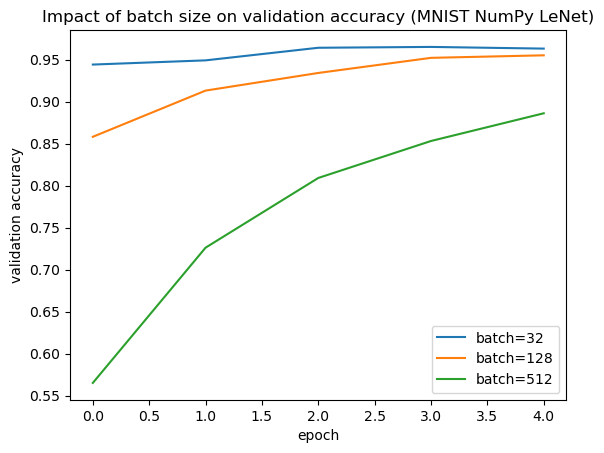

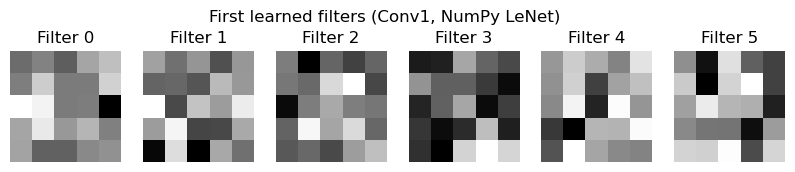

In [14]:
(Xtr, ytr), (Xval, yval), (Xte, yte), ncls = load_mnist()
n_sub, n_val = CFG['mnist']['subset'], CFG['mnist']['val_subset']
Xtr_s, ytr_s = Xtr[:n_sub].astype(np.float32), ytr[:n_sub]
Xval_s, yval_s = Xval[:n_val].astype(np.float32), yval[:n_val]

# 5. Training time benchmark
import time
start = time.time()
model = lenet_mnist(num_classes=ncls)
model, hist_mnist = train_numpy_model(model, Xtr_s, ytr_s, Xval_s, yval_s,
                                      epochs=CFG['mnist']['epochs'],
                                      batch_size=CFG['mnist']['batch'],
                                      lr=CFG['mnist']['lr'], num_classes=ncls)
end = time.time()
print(f"NumPy LeNet training time (MNIST subset): {end-start:.2f} sec")

# 2. Show learning rate for each epoch (Adam, constant lr)
print("Learning rate used for each epoch (Adam, constant):")
for ep in range(CFG['mnist']['epochs']):
    print(f"Epoch {ep+1}: lr = {CFG['mnist']['lr']}")

plot_history(hist_mnist, title_prefix='MNIST LeNet — ')

# Evaluate on held-out test set
model.eval()
logits_te = []
for s, e in make_batches(Xte.shape[0], CFG['mnist']['batch']):
    logits_te.append(model.forward(Xte[s:e].astype(np.float32), training=False))
logits_te = np.concatenate(logits_te, axis=0)
acc_te = accuracy(logits_te, yte)
y_pred = np.argmax(logits_te, axis=1)
cm = confusion_matrix(yte, y_pred, ncls)
print('MNIST test accuracy:', float(acc_te))
plot_confusion_matrix(cm, title='MNIST — Confusion Matrix (NumPy)')

# 3. Error analysis (misclassified images)
misclassified_idx = np.where(y_pred != yte)[0]
print(f"Number of misclassified images: {len(misclassified_idx)}")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for i, idx in enumerate(misclassified_idx[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(Xte[idx].squeeze(), cmap='gray')
    plt.title(f"True: {yte[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.suptitle("Examples of misclassified images (NumPy LeNet)")
plt.show()

# 4. Classification report (precision, recall, F1)
print("Classification report (NumPy LeNet on MNIST test):")
print(classification_report_np(yte, y_pred, labels=np.arange(ncls)))

# 6. Hyperparameter exploration (batch size)
batch_sizes = [32, 128, 512]
histories = {}
for bs in batch_sizes:
    model_bs = lenet_mnist(num_classes=ncls)
    _, hist_bs = train_numpy_model(model_bs, Xtr_s, ytr_s, Xval_s, yval_s,
                                  epochs=CFG['mnist']['epochs'],
                                  batch_size=bs, lr=CFG['mnist']['lr'], num_classes=ncls)
    histories[bs] = hist_bs

plt.figure()
for bs in batch_sizes:
    plt.plot(histories[bs]['val_acc'], label=f'batch={bs}')
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Impact of batch size on validation accuracy (MNIST NumPy LeNet)')
plt.legend()
plt.show()

# 7. Filter visualization
conv1_weights = model.layers[0].W  # assumes first layer is Conv2D
n_filters = min(6, conv1_weights.shape[0])
plt.figure(figsize=(10,2))
for i in range(n_filters):
    plt.subplot(1, n_filters, i+1)
    plt.imshow(conv1_weights[i,0], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')
plt.suptitle("First learned filters (Conv1, NumPy LeNet)")
plt.show()

## PyTorch comparison on MNIST subset
We train a small LeNet-like CNN in PyTorch on the **same subset** and compare test accuracy. If PyTorch is not installed, this section will skip gracefully.


PyTorch version: 2.5.1
[Torch ep 01] train_loss=1.7528 acc=0.4928 | val_loss=0.8774 acc=0.7100
[Torch ep 02] train_loss=0.5872 acc=0.8142 | val_loss=0.4618 acc=0.8490
[Torch ep 03] train_loss=0.3876 acc=0.8826 | val_loss=0.3699 acc=0.8740
[Torch ep 04] train_loss=0.2938 acc=0.9142 | val_loss=0.2813 acc=0.9100
[Torch ep 05] train_loss=0.2560 acc=0.9224 | val_loss=0.2276 acc=0.9360
PyTorch MNIST test acc: 0.9336


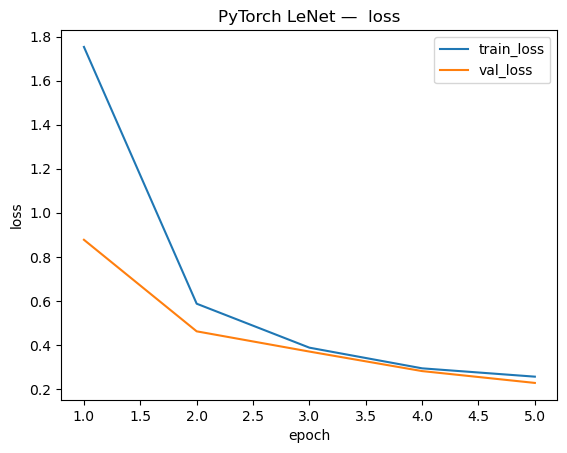

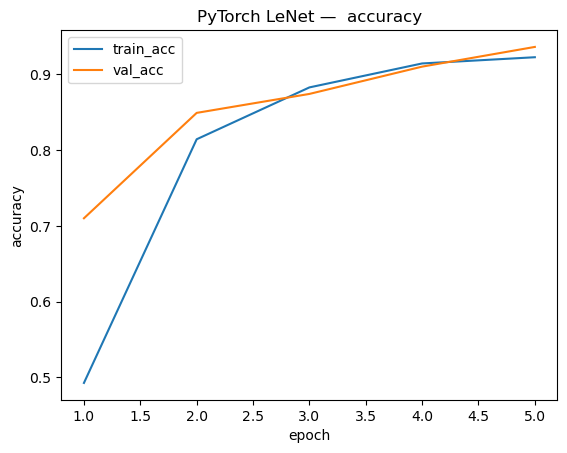

In [15]:
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    torch_available = True
    print('PyTorch version:', torch.__version__)
except Exception as e:
    torch_available = False
    print('PyTorch not available, skipping comparison. Error:', e)

if torch_available:
    class TorchLeNet(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
            self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
            self.fc1 = nn.Linear(16*5*5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)
        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, 2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # reload MNIST to avoid dtype side effects
    (Xtr, ytr), (Xval, yval), (Xte, yte), ncls = load_mnist()
    n_sub, n_val = CFG['mnist']['subset'], CFG['mnist']['val_subset']
    Xtr_s, ytr_s = Xtr[:n_sub].astype(np.float32), ytr[:n_sub]
    Xval_s, yval_s = Xval[:n_val].astype(np.float32), yval[:n_val]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = TorchLeNet(ncls).to(device)
    opt = optim.Adam(net.parameters(), lr=CFG['mnist']['lr'])
    criterion = nn.CrossEntropyLoss()

    def to_tensor(x):
        return torch.from_numpy(x).to(device)

    hist_t = defaultdict(list)
    net.train()
    batch = CFG['mnist']['batch']
    for ep in range(1, CFG['mnist']['epochs']+1):
        perm = np.random.permutation(Xtr_s.shape[0])
        Xtr_s, ytr_s = Xtr_s[perm], ytr_s[perm]
        total_loss = 0.0
        total_correct = 0
        total_seen = 0
        for s,e in make_batches(Xtr_s.shape[0], batch):
            xb = to_tensor(Xtr_s[s:e])
            yb = to_tensor(ytr_s[s:e]).long()
            opt.zero_grad()
            logits = net(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            total_loss += float(loss.item()) * (e - s)
            total_correct += int((logits.argmax(1) == yb).sum().item())
            total_seen += (e - s)
        train_loss = total_loss / total_seen
        train_acc = total_correct / total_seen
        # val
        net.eval()
        with torch.no_grad():
            val_logits = []
            for s,e in make_batches(Xval_s.shape[0], batch):
                val_logits.append(net(to_tensor(Xval_s[s:e])))
            val_logits = torch.cat(val_logits, dim=0)
            val_loss = float(criterion(val_logits, to_tensor(yval_s).long()).item())
            val_acc = float((val_logits.argmax(1) == to_tensor(yval_s).long()).float().mean().item())
        net.train()
        hist_t['train_loss'].append(train_loss)
        hist_t['train_acc'].append(train_acc)
        hist_t['val_loss'].append(val_loss)
        hist_t['val_acc'].append(val_acc)
        print(f"[Torch ep {ep:02d}] train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")

    # Test accuracy
    net.eval()
    with torch.no_grad():
        logits_te = []
        for s,e in make_batches(Xte.shape[0], batch):
            logits_te.append(net(to_tensor(Xte[s:e])))
        logits_te = torch.cat(logits_te, dim=0)
        acc_te_t = float((logits_te.argmax(1).cpu().numpy() == yte).mean())
    print('PyTorch MNIST test acc:', acc_te_t)

    # Plot Torch history
    plot_history(hist_t, title_prefix='PyTorch LeNet — ')
else:
    print('Install PyTorch to enable comparison: pip install torch torchvision')


## Summary
Compare final validation/test accuracies side-by-side.


In [16]:
# This cell relies on variables defined above; run the notebook sequentially.
try:
    print('MNIST — NumPy LeNet: last val acc =', hist_mnist['val_acc'][-1])
except Exception as e:
    print('MNIST — NumPy LeNet unavailable:', e)
try:
    if 'hist_t' in globals():
        print('MNIST — PyTorch LeNet: last val acc =', hist_t['val_acc'][-1])
except Exception as e:
    print('MNIST — PyTorch LeNet unavailable:', e)


MNIST — NumPy LeNet: last val acc = 0.946
MNIST — PyTorch LeNet: last val acc = 0.9359999895095825


## Limites et pistes d’amélioration

- Pas d’augmentation de données (rotation, shift, etc.)
- Pas de régularisation avancée (mixup, cutout, etc.)
- Pas de scheduler dynamique pour le learning rate
- Pas de support GPU, calcul lent pour grands datasets
- Pas de monitoring tensorboard ou wandb
- Pistes : ajouter augmentation, scheduler, tests sur d’autres architectures, visualisation